In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

os.getcwd() #check current working directory

/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv


'/kaggle/working'

In [2]:
# #install impyute to replace missing values (if not already installed)
# try:
#     import impyute
# except ImportError as e:
#     !pip install impyute # module doesn't exist, deal with it.
    
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import scipy.stats as scp

**LOAD & CHECK DATA**

In [3]:
#load data

# Read the data
train_data = pd.read_csv('../input/titanic/train.csv', index_col='PassengerId')
X_test_full = pd.read_csv('../input/titanic/test.csv', index_col='PassengerId')

#X.head()
y = train_data['Survived']
X = train_data.drop('Survived', axis=1)

#print(list(X.columns))

#print(y.head())
#print(X.head())


Check TRAIN data

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


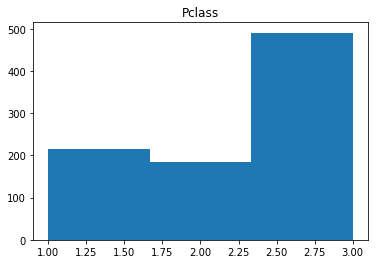

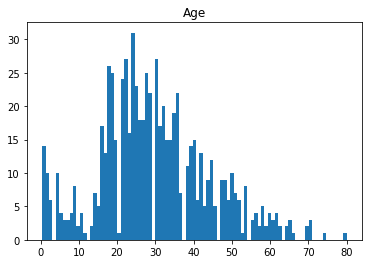

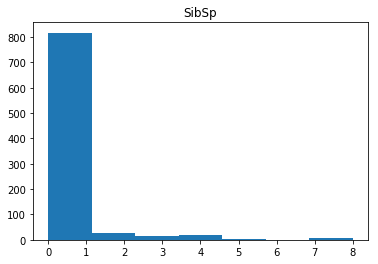

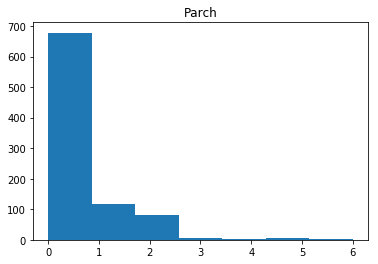

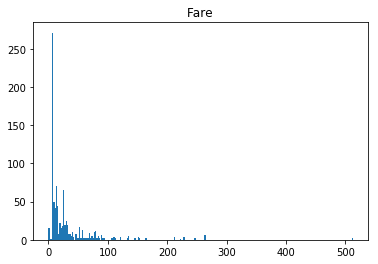

In [4]:
#visual check of data
X.describe(include = 'all')

import matplotlib.pyplot as plt
# visual check that distribution has passing resemblance
%matplotlib inline

num_features = ['Pclass','Age','SibSp','Parch','Fare']

for i in range(len(num_features)):
    plt.figure(i+1)
    plt.hist(X[num_features[i]],bins=len(X[num_features[i]].unique()))
    plt.title(num_features[i])

Check TEST data

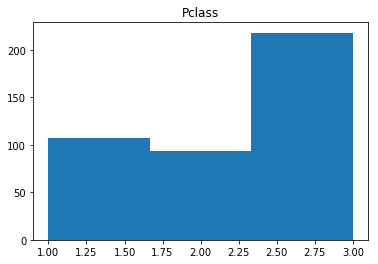

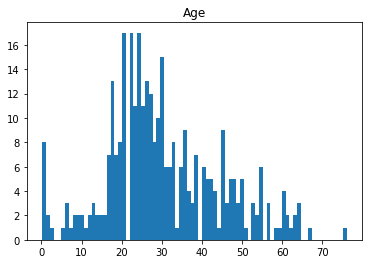

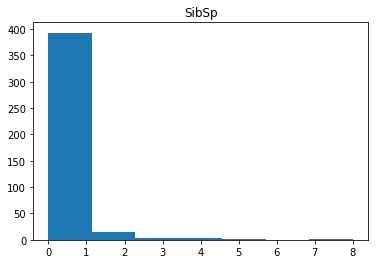

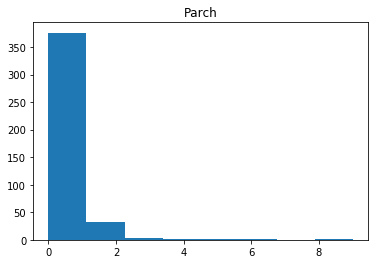

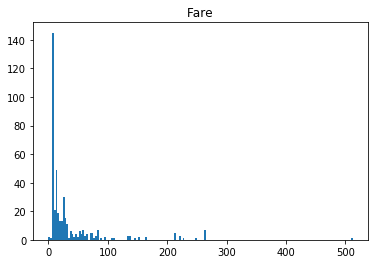

In [5]:
#visual check of data
X_test_full.describe(include = 'all')

import matplotlib.pyplot as plt
# visual check that distribution has passing resemblance
%matplotlib inline

num_features = ['Pclass','Age','SibSp','Parch','Fare']

for i in range(len(num_features)):
    plt.figure(i+1)
    plt.hist(X_test_full[num_features[i]],bins=len(X_test_full[num_features[i]].unique()))
    plt.title(num_features[i])

In [6]:
#manually remove impossible data
#X.Fare.sort_values().unique()
#X_test_full.Fare.sort_values().unique()

#since Fares != $0, remove 0 entries
X.Fare[X.Fare == 0] = float('NaN')
print('Train')
print(X.Fare.sort_values().unique())

X_test_full.Fare[X_test_full.Fare == 0] = float('NaN')
print('\nTest')
print(X_test_full.Fare.sort_values().unique())


Train
[  4.0125   5.       6.2375   6.4375   6.45     6.4958   6.75     6.8583
   6.95     6.975    7.0458   7.05     7.0542   7.125    7.1417   7.225
   7.2292   7.25     7.3125   7.4958   7.5208   7.55     7.6292   7.65
   7.725    7.7292   7.7333   7.7375   7.7417   7.75     7.775    7.7875
   7.7958   7.8      7.8292   7.8542   7.875    7.8792   7.8875   7.8958
   7.925    8.0292   8.05     8.1125   8.1375   8.1583   8.3      8.3625
   8.4042   8.4333   8.4583   8.5167   8.6542   8.6625   8.6833   8.7125
   8.85     9.       9.2167   9.225    9.35     9.475    9.4833   9.5
   9.5875   9.825    9.8375   9.8417   9.8458  10.1708  10.4625  10.5
  10.5167  11.1333  11.2417  11.5     12.      12.275   12.2875  12.35
  12.475   12.525   12.65    12.875   13.      13.4167  13.5     13.7917
  13.8583  13.8625  14.      14.1083  14.4     14.4542  14.4583  14.5
  15.      15.0458  15.05    15.1     15.2458  15.5     15.55    15.7417
  15.75    15.85    15.9     16.      16.1     16.7     17.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [7]:
#check missing values
print(' Training set: count of missing values')
print(X.isna().sum())
print('\n Testing set: count of missing values')
print(X_test_full.isna().sum())

 Training set: count of missing values
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare         15
Cabin       687
Embarked      2
dtype: int64

 Testing set: count of missing values
Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          3
Cabin       327
Embarked      0
dtype: int64


**PREPROCESSING**

Age
PassengerId
6      27.756856
18     33.718380
20     27.756856
27     27.756856
29     27.756856
         ...    
860    27.756856
864     0.420000
869    27.756856
879    27.756856
889    21.030944
Name: Age, Length: 177, dtype: float64

Fare
PassengerId
180     4.012500
264    70.537930
272     4.012500
278    36.397835
303     4.012500
414    36.397835
467    36.397835
482    36.397835
598     4.012500
634    70.537930
675    36.397835
733    36.397835
807    70.537930
816    70.537930
823    70.537930
Name: Fare, dtype: float64
             Pclass   Age  SibSp  Parch     Fare  \
PassengerId                                        
1                 3  22.0      1      0   7.2500   
2                 1  38.0      1      0  71.2833   
3                 3  26.0      0      0   7.9250   
4                 1  35.0      1      0  53.1000   
5                 3  35.0      0      0   8.0500   

                                                          Name     Sex  \
PassengerId        

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


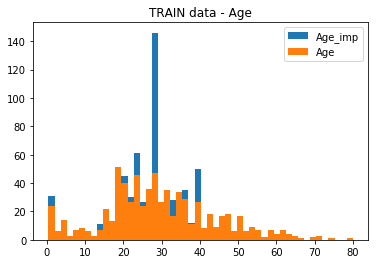

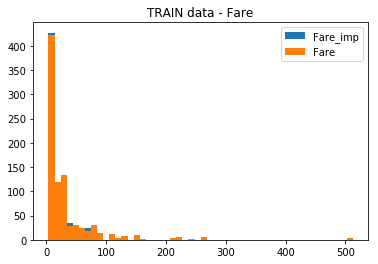

In [8]:
#replace missing values for Train data
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer


#replace missing values for numeric TRAIN data
X_num_data = X._get_numeric_data()
X_obj_data = X.select_dtypes(include='object') #save separately

#create new dataframe to replace imputed data
X_num_data_imp = X_num_data.copy(deep=True)

# start the MICE training for Age (Drop Fare) 
Imputer = IterativeImputer(min_value = X_num_data.Age.min())
X_Age_imp = X_num_data.copy(deep=True).drop('Fare', axis=1)
X_Age_imp.iloc[:,:] = Imputer.fit_transform(X_Age_imp)
X_num_data_imp.Age = X_Age_imp.Age #assign

# start the MICE training for Age (Drop Fare) 
Imputer = IterativeImputer(min_value = X_num_data.Fare.min())
X_Fare_imp = X_num_data.copy(deep=True).drop('Age', axis=1)
X_Fare_imp.iloc[:,:] = Imputer.fit_transform(X_Fare_imp)
X_num_data_imp.Fare = X_Fare_imp.Fare #assign

#check
print('Age')
print(X_num_data_imp.Age[X.Age.isnull()])
print('\nFare')
print(X_num_data_imp.Fare[X.Fare.isnull()])

# visual check that distribution has passing resemblance
%matplotlib inline

plt.figure(1)
plt.hist(X_num_data_imp.Age,bins=50,label='Age_imp')
plt.hist(X.Age,bins=50,label='Age')
plt.legend()
plt.title('TRAIN data - Age')

plt.figure(2)
plt.hist(X_num_data_imp.Fare,bins=50,label='Fare_imp')
plt.hist(X.Fare,bins=50,label='Fare')
plt.legend()
plt.title('TRAIN data - Fare')

#combine back into 1 dataframe
X_imp =  pd.concat([X_num_data_imp,X_obj_data],axis=1)

print(X_imp.head())

Age
PassengerId
902     24.257920
914     40.309229
921     21.745547
925     21.768015
928     24.257920
          ...    
1300    24.257920
1302    24.257920
1305    24.257920
1308    24.257920
1309    22.384874
Name: Age, Length: 86, dtype: float64

Fare
PassengerId
1044     4.012500
1158    77.542202
1264    77.542202
Name: Fare, dtype: float64


/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


             Pclass   Age  SibSp  Parch     Fare  \
PassengerId                                        
892               3  34.5      0      0   7.8292   
893               3  47.0      1      0   7.0000   
894               2  62.0      0      0   9.6875   
895               3  27.0      0      0   8.6625   
896               3  22.0      1      1  12.2875   

                                                     Name     Sex   Ticket  \
PassengerId                                                                  
892                                      Kelly, Mr. James    male   330911   
893                      Wilkes, Mrs. James (Ellen Needs)  female   363272   
894                             Myles, Mr. Thomas Francis    male   240276   
895                                      Wirz, Mr. Albert    male   315154   
896          Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  3101298   

            Cabin Embarked  
PassengerId                 
892           NaN        Q  
8

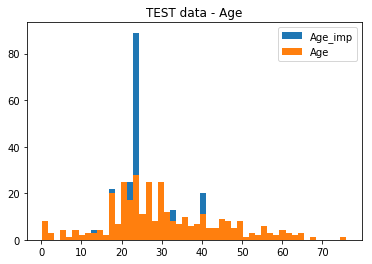

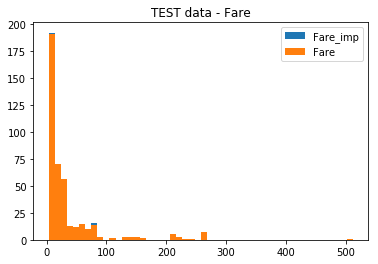

In [9]:
#replace missing values for Test data

#replace missing values for numeric TRAIN data
X_test_num_data = X_test_full._get_numeric_data()
X_test_obj_data = X_test_full.select_dtypes(include='object') #save separately

#create new dataframe to replace imputed data
X_test_num_data_imp = X_test_num_data.copy(deep=True)

# start the MICE training for Age (Drop Fare) 
Imputer = IterativeImputer(min_value = X_test_num_data.Age.min())
X_test_Age_imp = X_test_num_data.copy(deep=True).drop('Fare', axis=1)
X_test_Age_imp.iloc[:,:] = Imputer.fit_transform(X_test_Age_imp)
X_test_num_data_imp.Age = X_test_Age_imp.Age #assign

# start the MICE training for Age (Drop Fare) 
Imputer = IterativeImputer(min_value = X_num_data.Fare.min())
X_test_Fare_imp = X_test_num_data.copy(deep=True).drop('Age', axis=1)
X_test_Fare_imp.iloc[:,:] = Imputer.fit_transform(X_test_Fare_imp)
X_test_num_data_imp.Fare = X_test_Fare_imp.Fare #assign

#check
print('Age')
print(X_test_num_data_imp.Age[X_test_full.Age.isnull()])
print('\nFare')
print(X_test_num_data_imp.Fare[X_test_full.Fare.isnull()])

# visual check that distribution has passing resemblance
%matplotlib inline

plt.figure(1)
plt.hist(X_test_num_data_imp.Age,bins=50,label='Age_imp')
plt.hist(X_test_full.Age,bins=50,label='Age')
plt.legend()
plt.title('TEST data - Age')

plt.figure(2)
plt.hist(X_test_num_data_imp.Fare,bins=50,label='Fare_imp')
plt.hist(X_test_full.Fare,bins=50,label='Fare')
plt.legend()
plt.title('TEST data - Fare')

#combine back into 1 dataframe
X_test_full_imp =  pd.concat([X_test_num_data_imp,X_test_obj_data],axis=1)

print(X_test_full_imp.head())

In [10]:
#create new feature - Title 
#credit to https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if str.find(big_string, substring) != -1:
            return substring
    print(big_string)
    return np.nan

#assign title
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']

X_imp['Title']=X_imp['Name'].map(lambda x: substrings_in_string(x, title_list))

#replacing all titles with mr_hon, mrs_hon, mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr_Hon'
    elif title in ['Countess', 'Mme']:
        return 'Mrs_Hon'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
X_imp['Title']=X_imp.apply(replace_titles, axis=1)

    
#replace the 2 missing Embarked values in training set with modal value
X_imp['Embarked'].fillna(X_imp['Embarked'].mode()[0], inplace = True)


#do the same for test data
X_test_full_imp['Title']=X_test_full_imp['Name'].map(lambda x: substrings_in_string(x, title_list))
X_test_full_imp['Title']=X_test_full_imp.apply(replace_titles, axis=1)

In [11]:
#create new feature - relatives
X_imp['Relatives']=X_imp['SibSp']+X_imp['Parch']

#do the same for test data
X_test_full_imp['Relatives']=X_test_full_imp['SibSp']+X_test_full_imp['Parch']

#create new feature - child (if Age < 16)
X_imp['Child'] = (X_imp.Age < 16).astype(int)

#create new feature - child (if Age < 16)
X_test_full_imp['Child'] = (X_test_full_imp.Age < 16).astype(int)

#select relevant features
num_features = ['Pclass', 'Age', 'Fare', 'Relatives','Child']
obj_features = ['Sex','Embarked', 'Title']

X_working = pd.concat([X_imp[num_features],
                             pd.get_dummies(X_imp.Sex,prefix='Sex'),
                             pd.get_dummies(X_imp.Embarked,prefix='Embarked'),
                             pd.get_dummies(X_imp.Title,prefix='Title')],axis=1)     

X_test_working = pd.concat([X_test_full_imp[num_features],
                             pd.get_dummies(X_test_full_imp.Sex,prefix='Sex'),
                             pd.get_dummies(X_test_full_imp.Embarked,prefix='Embarked'),
                             pd.get_dummies(X_test_full_imp.Title,prefix='Title')],axis=1)  

In [12]:
#check for mismatched columns
print(list(X_working.columns))
print(list(X_test_working.columns))

['Pclass', 'Age', 'Fare', 'Relatives', 'Child', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mr_Hon', 'Title_Mrs', 'Title_Mrs_Hon']
['Pclass', 'Age', 'Fare', 'Relatives', 'Child', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mr_Hon', 'Title_Mrs']


In [13]:
#test set doesn't have aristocrat female (to automate in future)
X_test_working['Title_Mrs_Hon']=0

#check that features match
print(list(X_test_working.columns))

['Pclass', 'Age', 'Fare', 'Relatives', 'Child', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mr_Hon', 'Title_Mrs', 'Title_Mrs_Hon']


In [14]:
#check
X_test_working.head()

,Pclass,Age,Fare,Relatives,Child,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mr_Hon,Title_Mrs,Title_Mrs_Hon
PassengerId,,,,,,,,,,,,,,,,
892,3,34.5,7.8292,0,0,0,1,0,1,0,0,0,1,0,0,0
893,3,47.0,7.0000,1,0,1,0,0,0,1,0,0,0,0,1,0
894,2,62.0,9.6875,0,0,0,1,0,1,0,0,0,1,0,0,0
895,3,27.0,8.6625,0,0,0,1,0,0,1,0,0,1,0,0,0
896,3,22.0,12.2875,2,0,1,0,0,0,1,0,0,0,0,1,0


**GRIDSEARCH**

In [15]:
from sklearn.model_selection import GridSearchCV

X_train, X_valid, y_train, y_valid = train_test_split(X_working, y, train_size=0.8, test_size=0.2)

my_model = XGBRegressor()

parameters = {'objective':['reg:logistic','binary:logistic'],
              'learning_rate': [0.3,0.1,0.05,0.01,0.001], #so called `eta` value
              'max_depth': [2,4,6,8,10,12],
              'n_estimators': [100,500,1000,2000,3000],
              'min_child_weight':[0.01,0.1,0.5,1,2],
              'max_delta_step':[0,1,5,10]}

grid = GridSearchCV(my_model, parameters,cv=10, n_jobs = -1)

grid.fit(X_train, y_train, 
                 early_stopping_rounds=5, 
                 eval_set=[(X_valid, y_valid)],
                 verbose=False) # Your code here

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0...
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.3, 0.1, 0.05, 0.01, 0.001],
                         'max_delta_step': [0, 1, 5, 10],
                         'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_child_weight': [0.01, 0.1, 0.5, 1, 2],
    

In [16]:
Ressie = pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
#print(Ressie[Ressie.mean_test_score==Ressie.mean_test_score.max()]['params'].iloc[0])
print(grid.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.3, max_delta_step=1,
             max_depth=4, min_child_weight=0.01, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:logistic', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)


**MODEL & PREDICT**

In [19]:
#since logreg outputs continuous probabilities, making multiple predictions and averaging them may give better 
#estimates of survival predictions

from sklearn.metrics import accuracy_score

all_pred=[]

for i in range(10):
    X_train, X_valid, y_train, y_valid = train_test_split(X_working, y, train_size=0.8, test_size=0.2)

    #based on GridSearchCV, use model with best performing parameters
    my_model = XGBRegressor(objective='reg:logistic',n_estimators=100,learning_rate=0.3,
                            max_depth=4,min_child_weight=0.01,max_delta_step=1)
    

    my_model.fit(X_train, y_train, 
                 early_stopping_rounds=5, 
                 eval_set=[(X_valid, y_valid)],
                 verbose=False)

    train_predictions = my_model.predict(X_valid)

    print(accuracy_score(y_valid,train_predictions.round()))
    
    all_pred.append(my_model.predict(X_test_working))

print('\ncompleted ' + str(i+1) + ' predictions for test set')

0.8379888268156425
0.8435754189944135
0.88268156424581
0.8715083798882681
0.8268156424581006
0.8770949720670391
0.8435754189944135
0.8212290502793296
0.8212290502793296
0.8379888268156425

completed 10 predictions for test set


In [20]:
#all_pred
predictions = np.round(sum(all_pred)/len(all_pred)).astype(int)
print(predictions)
print(np.mean(predictions))

[0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 1]
0.35167464114832536


**WRITE OUTPUT FILE**

In [21]:
#write output for competition

from datetime import datetime

#get date for filename
now = datetime.now() # current date and time
date = now.strftime("%d%m%Y")
#print("date",date)

output = pd.DataFrame({'PassengerId': X_test_working.index, 'Survived': predictions})
output.to_csv('submission_XK_'+date+'.csv', index=False)
#print("Your submission was successfully saved!")
print(predictions)

[0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 1]


**MISC/TESTING**

#try 2

from sklearn.metrics import accuracy_score

all_pred=[]

for i in range(10):
    X_train, X_valid, y_train, y_valid = train_test_split(X_working, y, train_size=0.8, test_size=0.2)

    my_model = XGBRegressor(objective='reg:logistic',n_estimators=500,learning_rate=0.025,
                             verbosity=0, max_depth=10)

    my_model.fit(X_train, y_train, 
                 early_stopping_rounds=20, 
                 eval_set=[(X_valid, y_valid)],
                 verbose=False)

    train_predictions = my_model.predict(X_valid)

    print(accuracy_score(y_valid,train_predictions.round()))
    
    all_pred.append(my_model.predict(X_test_working))

print('\ncompleted ' + str(i+1) + ' predictions for test set')

#try 3
from sklearn.metrics import accuracy_score

for i in range(5):
    X_train, X_valid, y_train, y_valid = train_test_split(X_working, y, train_size=0.8, test_size=0.2)

    my_model = XGBClassifier(objective='binary:logistic',n_estimators=500,learning_rate=0.05,
                             verbosity=0, max_depth=5)

    my_model.fit(X_train, y_train, 
                 early_stopping_rounds=20, 
                 eval_set=[(X_valid, y_valid)],
                 verbose=False) # Your code here

    predictions = my_model.predict(X_valid)

    print(accuracy_score(y_valid,predictions))

predictions = my_model.predict(X_test_working)
print('\ncompleted predictions for test set')

#replace missing values for numeric TEST data
X_test_num_data = X_test_full._get_numeric_data()
X_test_obj_data = X_test_full.select_dtypes(include='object') #save separately

# start the MICE training 
X_test_num_data_imp = pd.DataFrame(mice(X_test_num_data.values))
X_test_num_data_imp.columns = X_test_num_data.columns
X_test_num_data_imp.index = X_test_num_data.index

#Since Age values cannot be <0, replace with an Age value of passenger with the closest Fare value
if not X_test_num_data_imp.Age[X_test_num_data_imp.Age < 0].empty: #if there are negative Age values
    #find modal fare of passengers with negative Age
    FX = X_test_num_data_imp.Fare[X_test_num_data_imp.Age < 0]
    mX = scp.mode(FX)
    mX = float(mX[0])

    #find closest fare values
    F = np.sort(X_test_num_data_imp.Fare.unique())
    neg_ind = np.where(F == mX)
    neg_ind = int(neg_ind[0])

    #replace with modal Age values based on closest fare values
    if(abs(F[neg_ind - 1] - F[neg_ind]) < abs(F[neg_ind + 1] - F[neg_ind])):
        FA = X_test_num_data_imp.Age[X_test_num_data_imp.Fare == F[neg_ind - 1]]
    else:
        FA = X_test_num_data_imp.Age[X_test_num_data_imp.Fare == F[neg_ind + 1]]

    mA = scp.mode(FA)
    mA = float(mA[0])
    X_test_num_data_imp.Age[X_test_num_data_imp.Age < 0] = mA

# visual check that distribution has passing resemblance
%matplotlib inline

plt.figure(1)
plt.hist(X_test_num_data_imp.Age,bins=50,label='Age_imp')
plt.hist(X_test_full.Age,bins=50,label='Age')
plt.legend()
plt.title('TEST data')

plt.figure(2)
plt.hist(X_test_num_data_imp.Age,bins=50,label='Age_imp')
plt.hist(X_test_full.Age,bins=50,label='Age')
plt.legend()
plt.title('TEST data')

#combine back into 1 dataframe
X_test_full_imp =  pd.concat([X_test_num_data_imp,X_test_obj_data],axis=1)

In [ ]:
X_working.Fare

my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

CHECK ACC OF BASIC MODEL

##Basic RFR model

from sklearn.ensemble import RandomForestClassifier

train_data = pd.read_csv('../input/titanic/train.csv', index_col='PassengerId')
test_data = pd.read_csv('../input/titanic/test.csv', index_col='PassengerId')

y = train_data["Survived"]
features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
scores = cross_val_score(model, X, y, cv=10,scoring='accuracy')
print(scores.mean())

#model.fit(X_working, y)
#predictions = model.predict(X_test_working)

#output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
#output.to_csv('my_submission.csv', index=False)
#print("Your submission was successfully saved!")
#print(predictions)